# Impact of Covid-19 on House Price Index for the United States

In [8]:
!pip install pandas

     |████████████████████████████████| 11.5 MB 17.1 MB/s eta 0:00:01


In [170]:
import pandas as pd
from datetime import timedelta

import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns

In [197]:
covid_df = pd.read_csv('../data/external/us-states.csv')
covid_df.columns = ['date', 'state', 'fips', 'cumulative_cases', 'cumulative_deaths']
covid_df.date = pd.to_datetime(covid_df.date)
covid_df = covid_df.sort_values(by=['state','date']).reset_index(drop=True)
covid_df['year'] = covid_df.date.dt.year
covid_df['month'] = covid_df.date.dt.month
covid_df['year_month'] = covid_df.date.dt.strftime('%Y-%m')

## Data cleaning

* set Florida negative date to 0

In [213]:
previous_day = covid_df[(covid_df.date == '2021-06-03') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
next_day = covid_df[(covid_df.date == '2021-06-04') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
print(f"Cumulative cases on 2021-06-03: {previous_day}")
print(f"Cumulative cases on 2021-06-04: {next_day}")
print(f"Diff: {next_day - previous_day}")

Cumulative cases on 2021-06-03: 2329859
Cumulative cases on 2021-06-04: 2289332
Diff: -40527


In [198]:
deaths = []
cases = []
for i in range(len(covid_df)):
    state = covid_df.state[i]
    previous_day = covid_df.date[i] - timedelta(days=1)
    previows_row = covid_df[(covid_df.state == state) & (covid_df.date == previous_day)]
    if len(previows_row):
        deaths.append(max(0, covid_df.cumulative_deaths[i] - previows_row.cumulative_deaths.iloc[0]))
        cases.append(max(0, covid_df.cumulative_cases[i] - previows_row.cumulative_cases.iloc[0]))
    else:
        deaths.append(covid_df.cumulative_deaths[i])
        cases.append(covid_df.cumulative_cases[i])

covid_df['deaths'] = deaths 
covid_df['cases'] = cases

In [214]:
rolling_deaths = []
rolling_cases = []

for state in sorted(covid_df.state.unique()):
    state_filtered = covid_df[covid_df.state == state].reset_index()
    state_rolling_deaths = state_filtered['deaths'].rolling(7).mean()
    state_rolling_cases = state_filtered['cases'].rolling(7).mean()
    rolling_deaths += state_rolling_deaths.to_list()
    rolling_cases += state_rolling_cases.to_list()
    
covid_df['7day_avg_deaths'] = rolling_deaths
covid_df['7day_avg_cases'] = rolling_cases

In [215]:
covid_df.head()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month,deaths,cases,7day_avg_deaths,7day_avg_cases
0,2020-03-13,Alabama,1,6,0,2020,3,2020-03,0,6,NaN,NaN
1,2020-03-14,Alabama,1,12,0,2020,3,2020-03,0,6,NaN,NaN
2,2020-03-15,Alabama,1,23,0,2020,3,2020-03,0,11,NaN,NaN
3,2020-03-16,Alabama,1,29,0,2020,3,2020-03,0,6,NaN,NaN
4,2020-03-17,Alabama,1,39,0,2020,3,2020-03,0,10,NaN,NaN


In [216]:
covid_df.tail()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month,deaths,cases,7day_avg_deaths,7day_avg_cases
31249,2021-09-17,Wyoming,56,83958,918,2021,9,2021-09,0,315,5.571429,473.571429
31250,2021-09-18,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
31251,2021-09-19,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
31252,2021-09-20,Wyoming,56,85499,918,2021,9,2021-09,0,1541,5.571429,524.857143
31253,2021-09-21,Wyoming,56,86052,955,2021,9,2021-09,37,553,5.285714,512.714286


In [217]:
us_covid = covid_df[['deaths','cases','date']].groupby(["date"]).sum().reset_index()
us_covid['year_month'] = us_covid.date.dt.strftime('%Y-%m')
us_covid['day_avg_deaths'] = us_covid['deaths'].rolling(7).mean()
us_covid['day_avg_cases'] = us_covid['cases'].rolling(7).mean()

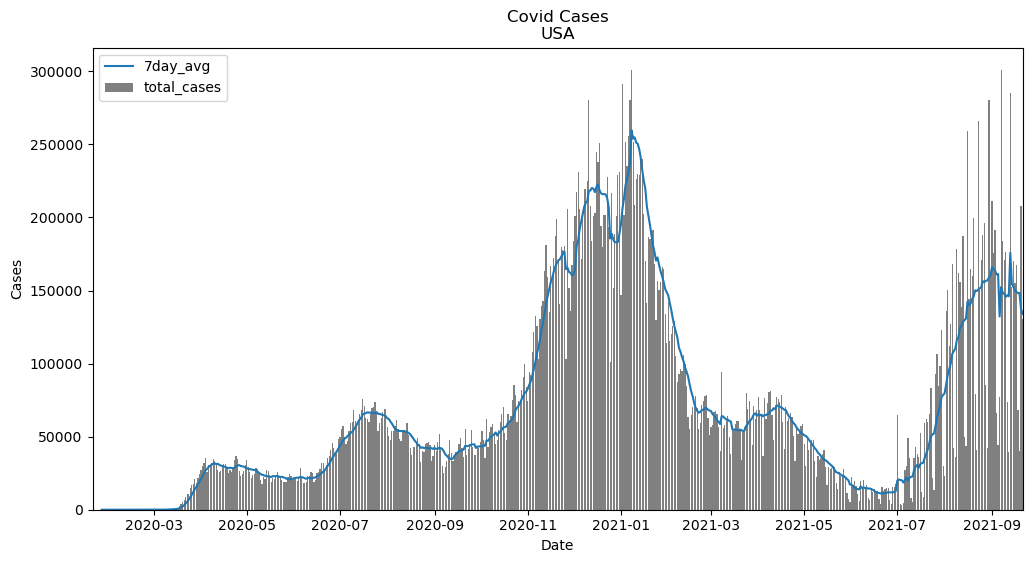

In [219]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(us_covid.date,
       us_covid.cases,
       color='gray',
      label="total_cases")
ax.plot(us_covid.date,us_covid.day_avg_cases, label='7day_avg')
ax.set(xlabel="Date",
       ylabel="Cases",
       title="Covid Cases\nUSA",
       xlim=[min(us_covid.date), max((us_covid.date))])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [195]:
us_covid[us_covid.cases < 0]

,date,deaths,cases,year_month,day_avg_deaths,day_avg_cases
500,2021-06-04,139,-23999,2021-06,353.571429,8486.428571


In [159]:
covid_df.to_csv('../data/processed/us-states.csv')

In [160]:
us_monthly_cases = covid_df[['deaths','cases','year','month']].groupby(["year","month"]).sum().reset_index()

In [161]:
us_monthly_cases.head()

,year,month,deaths,cases,7day_avg_deaths,7day_avg_cases
0,2020,1,0,7,0.000000,1.000000
1,2020,2,1,63,0.142857,34.857143
2,2020,3,4303,188391,2408.000000,124830.285714
3,2020,4,58836,887295,54415.142857,869054.000000
4,2020,5,41239,723546,44623.142857,738987.285714


In [142]:
us_monthly_cases.describe()

,year,month,deaths,cases
count,21.000000,21.000000,21.000000,2.100000e+01
mean,2020.428571,5.857143,32312.238095,2.019256e+06
std,0.507093,3.275450,25471.795902,1.872243e+06
min,2020.000000,1.000000,0.000000,7.000000e+00
25%,2020.000000,3.000000,18684.000000,8.540190e+05
50%,2020.000000,6.000000,26400.000000,1.473788e+06
75%,2021.000000,8.000000,38679.000000,2.402731e+06
max,2021.000000,12.000000,95249.000000,6.409480e+06


In [11]:
house_prices_df = pd.read_csv('../data/external/HPI_master.csv')
house_prices_df.head(5)

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,100.00
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,100.93,100.99
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.31,100.91
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.71,101.00
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.32,101.35


In [5]:
covid_df.cases.sum()

10186164431

In [6]:
covid_df.describe()

,fips,cases,deaths
count,31254.000000,3.125400e+04,31254.000000
mean,31.965412,3.259155e+05,6204.149325
std,18.669047,5.635577e+05,10267.243885
min,1.000000,1.000000e+00,0.000000
25%,17.000000,1.683425e+04,365.000000
50%,31.000000,1.114910e+05,2087.000000
75%,46.000000,4.131408e+05,7385.500000
max,78.000000,4.669895e+06,68244.000000


* total cases vs avg USA
* Comparisson by states
* select states for study
* plot historical data for house index
* Combine both datasets into one for USA, and other for states 
* plot comparison between house index and covid for covid dates
* Calculate correlation